<a href="https://colab.research.google.com/github/caitlinmac/heart-beat-decoder/blob/model-colab/Enrika_Basic_Model-COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
import os

file_path = '/content/INCART 2-lead Arrhythmia Database.csv'

if not os.path.exists(file_path):
    print("File not found")
else:
    data = pd.read_csv(file_path)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# data = pd.read_csv('/Users/enrikasoucy/Downloads/archive (13)/INCART 2-lead Arrhythmia Database.csv')

In [4]:
subset_fraction = 1.0
data_subset = data.sample(frac=subset_fraction, random_state=42)

In [5]:
data_subset.head()

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
28908,I12,N,196,193,-0.053282,-0.411673,1.591223,-0.690581,-0.068750,18,...,-0.022131,6.0,2.0,15.0,7.0,-0.022131,-0.116368,-0.241496,-0.379801,-0.507499
78394,I34,N,267,317,-0.074312,-0.311586,1.144363,-0.612171,-0.119342,18,...,-0.361235,4.0,5.0,25.0,16.0,-0.361235,-0.361235,-0.568532,-0.754135,-0.881001
41966,I18,N,134,137,0.269407,1.359665,-0.006546,-0.006546,-0.231990,11,...,-0.080435,16.0,8.0,32.0,8.0,-0.080435,-0.061559,0.050498,0.130689,-0.561149
1424,I01,N,170,102,-0.068883,-0.122126,0.685096,-0.342469,-0.112441,17,...,0.086706,14.0,3.0,23.0,6.0,0.086706,0.113618,0.223352,0.165030,-0.225114
76023,I33,N,346,333,0.101155,-0.359626,1.119283,-0.563086,-0.120834,27,...,-0.352931,4.0,5.0,24.0,15.0,-0.352931,-0.352931,-0.565260,-0.773874,-0.938588


In [6]:
data_subset.shape

(82366, 34)

In [7]:
type_mapping = {
    'N': 'Normal',
    'SVEB': 'Abnormal',
    'VEB': 'Abnormal',
    'F': 'Abnormal',
    'Q': 'Abnormal'
}
data_subset['type'] = data_subset['type'].map(type_mapping)

In [8]:
type_counts = data_subset['type'].value_counts()

In [9]:
binary_type_names = {
    'Normal': 'Normal',
    'Abnormal': 'Abnormal'
}

print("Counts of Each Type:")
for type_code, count in type_counts.items():
    print(f"{binary_type_names[type_code]}: {count}")

Counts of Each Type:
Normal: 73102
Abnormal: 9264


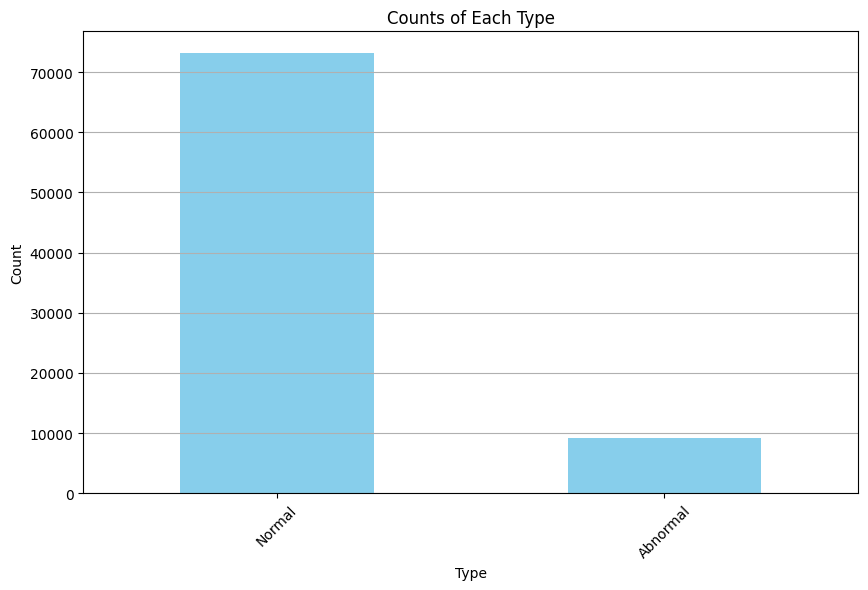

In [10]:
type_counts.index = type_counts.index.map(binary_type_names)

plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', color='skyblue')
plt.title('Counts of Each Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [11]:
data_subset = data_subset.drop(columns=['record'])

In [12]:
data_subset.head()

,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,0_pq_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
28908,Normal,196,193,-0.053282,-0.411673,1.591223,-0.690581,-0.068750,18,4,...,-0.022131,6.0,2.0,15.0,7.0,-0.022131,-0.116368,-0.241496,-0.379801,-0.507499
78394,Normal,267,317,-0.074312,-0.311586,1.144363,-0.612171,-0.119342,18,4,...,-0.361235,4.0,5.0,25.0,16.0,-0.361235,-0.361235,-0.568532,-0.754135,-0.881001
41966,Normal,134,137,0.269407,1.359665,-0.006546,-0.006546,-0.231990,11,13,...,-0.080435,16.0,8.0,32.0,8.0,-0.080435,-0.061559,0.050498,0.130689,-0.561149
1424,Normal,170,102,-0.068883,-0.122126,0.685096,-0.342469,-0.112441,17,5,...,0.086706,14.0,3.0,23.0,6.0,0.086706,0.113618,0.223352,0.165030,-0.225114
76023,Normal,346,333,0.101155,-0.359626,1.119283,-0.563086,-0.120834,27,19,...,-0.352931,4.0,5.0,24.0,15.0,-0.352931,-0.352931,-0.565260,-0.773874,-0.938588


In [13]:
X = data_subset.drop('type', axis=1)
y = data_subset['type']

In [14]:
binary_type_mapping = {'Normal': 0, 'Abnormal': 1}
y = y.map(binary_type_mapping)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [16]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [18]:
# subset_size = 5000
X_train_subsample = X_train_resampled
y_train_subsample = y_train_resampled

model = RandomForestClassifier(random_state=101, n_estimators=50)

In [19]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train_subsample, y_train_subsample, cv=cv, scoring='accuracy')
print("Cross-val scores: ", scores)
print("Avg cross-val score: ", scores.mean())

Cross-val scores:  [0.99769162 0.9979481  0.99794802 0.99790527 0.99786252]
Avg cross-val score:  0.9978711043115485


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train_subsample, y_train_subsample)

print("Best params: ", grid_search.best_params_)
print("Best cross-val score: ", grid_search.best_score_)

In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(X_train_subsample, y_train_subsample)
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("*** Confusion Matrix ***")
print(confusion_matrix(y_test, y_pred))
print("*** Classification Report ***")
print(classification_report(y_test, y_pred, target_names=list(binary_type_names.values())))

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train_subsample, y_train_subsample, cv=cv, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy Score')
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()